## Importing Libraries

In [22]:
import pandas as pd
import datetime
import time
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns  #Plots
from matplotlib import rcParams  #Size of plots  
%matplotlib inline
import math
import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


## Loading Processed Dataframes

In [23]:
pickle_file = open('3_month_data_2022.pkl', 'rb') 

Jan_22_df_proc = pickle.load(pickle_file)
Jan_22_df_grpby = pickle.load(pickle_file)

Feb_22_df_proc = pickle.load(pickle_file)
Feb_22_df_grpby = pickle.load(pickle_file)

Mar_22_df_proc = pickle.load(pickle_file)
Mar_22_df_grpby = pickle.load(pickle_file)

pickle_file = open('3_month_data_2023.pkl', 'rb') 

Jan_23_df_proc = pickle.load(pickle_file)
Jan_23_df_grpby = pickle.load(pickle_file)

Feb_23_df_proc = pickle.load(pickle_file)
Feb_23_df_grpby = pickle.load(pickle_file)

Mar_23_df_proc = pickle.load(pickle_file)
Mar_23_df_grpby = pickle.load(pickle_file)


In [24]:
# GroupBy dataframe has two indices
# primary index: PULocationID (Region number)
# secondary index : pickup_bins (we divide whole months time into 10min intravels 24*31*60/10 = 4464 bins )

In [25]:
# Gets the unique bins where pickup values are present for each each region
# for each LocationID we will collect all the indices of 10min intervals in which the pickups have happened

def return_unq_pickup_bins(frame):
    values = []
    for i in range(1,266):
        if i not in frame.PULocationID.unique():
            values.append([])
            continue
        new = frame[frame['PULocationID'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [27]:
# A sample of unique bins for each 265 regions

Jan_22_df_unique = return_unq_pickup_bins(Jan_22_df_proc)
print(len(Jan_22_df_unique))
print(Jan_22_df_unique[0:5])

265
[[93, 178, 229, 247, 387, 797, 915, 2218, 2537, 3234, 4258], [1269, 4269], [652, 656, 799, 801, 975, 1498, 1506, 1671, 1771, 1969, 2083, 2249, 2370, 2386, 2519, 2626, 2630, 2809, 3214, 3375, 3527, 3529, 3840, 3917], [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 32, 33, 35, 37, 38, 40, 46, 54, 56, 59, 65, 69, 71, 72, 74, 83, 85, 86, 89, 94, 99, 101, 104, 107, 109, 114, 116, 120, 121, 122, 127, 129, 130, 131, 132, 133, 134, 145, 157, 160, 192, 202, 206, 211, 215, 218, 221, 222, 223, 226, 228, 229, 235, 236, 237, 239, 244, 245, 246, 249, 250, 254, 259, 260, 264, 282, 286, 299, 314, 318, 328, 333, 334, 336, 342, 343, 344, 348, 353, 355, 356, 359, 360, 370, 372, 376, 377, 378, 380, 382, 384, 385, 387, 388, 392, 396, 399, 402, 410, 415, 416, 417, 418, 419, 429, 430, 433, 440, 463, 464, 466, 470, 473, 474, 475, 478, 481, 483, 484, 485, 486, 487, 491, 493, 495, 496, 497, 498, 499, 502, 504, 506, 511, 513, 514, 516, 517, 518, 519, 520, 

In [28]:
# Getting unique bins for all the months

Jan_22_df_unique = return_unq_pickup_bins(Jan_22_df_proc)
Feb_22_df_unique = return_unq_pickup_bins(Feb_22_df_proc)
Mar_22_df_unique = return_unq_pickup_bins(Mar_22_df_proc)

Jan_23_df_unique = return_unq_pickup_bins(Jan_23_df_proc)
Feb_23_df_unique = return_unq_pickup_bins(Feb_23_df_proc)
Mar_23_df_unique = return_unq_pickup_bins(Mar_23_df_proc)


In [29]:
# Calculating the number of 10min intervals/bins with zero pickups for each region in the month of Jan 2022
temp_lis = []
temp_lis_non_zero = []
for i in range(0,265):
    print("for the ",i,"th cluster number of 10min intervals with zero pickups: ",4464 - len(set(Feb_22_df_unique[i])))
    temp = [i,4464 - len(set(Jan_22_df_unique[i]))]
    temp_lis.append(temp)
    temp_non_zero = [i,len(set(Jan_22_df_unique[i]))]
    temp_lis_non_zero.append(temp_non_zero)
    print('-'*60)

for the  0 th cluster number of 10min intervals with zero pickups:  4455
------------------------------------------------------------
for the  1 th cluster number of 10min intervals with zero pickups:  4461
------------------------------------------------------------
for the  2 th cluster number of 10min intervals with zero pickups:  4433
------------------------------------------------------------
for the  3 th cluster number of 10min intervals with zero pickups:  2561
------------------------------------------------------------
for the  4 th cluster number of 10min intervals with zero pickups:  4436
------------------------------------------------------------
for the  5 th cluster number of 10min intervals with zero pickups:  4462
------------------------------------------------------------
for the  6 th cluster number of 10min intervals with zero pickups:  3213
------------------------------------------------------------
for the  7 th cluster number of 10min intervals with zero pick

<Axes: xlabel='Cluster ID'>

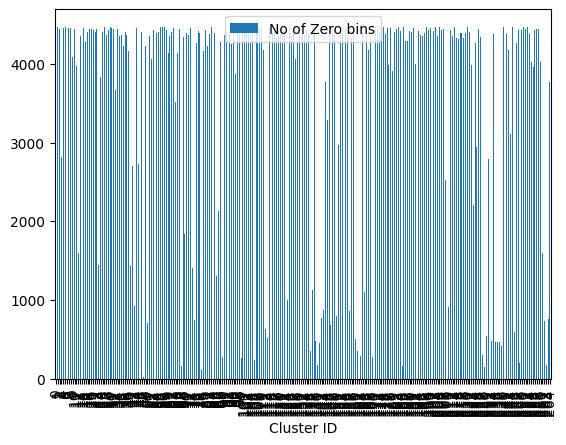

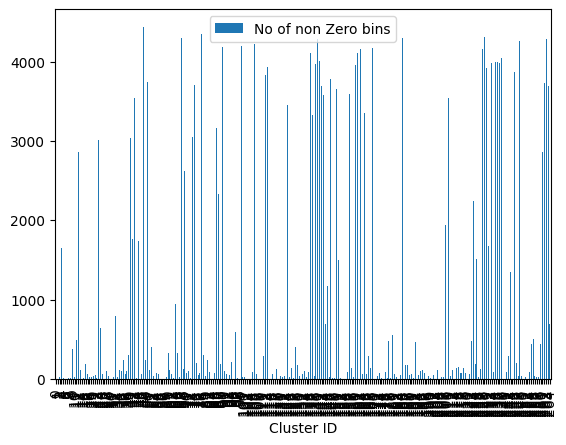

In [31]:

# Plotting the number of zero bins for each region in plot 1 (Jan 2022)

df_temp_lis = pd.DataFrame(temp_lis, columns=['Cluster ID', 'No of Zero bins'])
df_temp_lis.plot(x='Cluster ID', y='No of Zero bins', kind='bar')

# Plotting the number of non-zero bins for each region in plot 2 (Jan 2022)

df_temp_lis_non_zero = pd.DataFrame(temp_lis_non_zero, columns=['Cluster ID', 'No of non Zero bins'])
df_temp_lis_non_zero.plot(x='Cluster ID', y='No of non Zero bins', kind='bar')


In [32]:
display(df_temp_lis_non_zero)

,Cluster ID,No of non Zero bins
0,0,11
1,1,2
2,2,24
3,3,1651
4,4,12
...,...,...
260,260,2864
261,261,3728
262,262,4286
263,263,3699


In [35]:
# for every 10min intravel(pickup_bin) we will check if it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data

def fill_missing(count_values, values, range_start, range_end):
    """
    Fills a value of zero for every bin where no pickup data is present since there wont be any values if there are no pickups.

    Parameters:
    count_values (list): Number pickps that happened in each region for each 10min intravel
    values (list): A list of list containing non zero unique bin numbers.
    range_start (int): The starting index of the range.
    range_end (int): The ending index of the range.

    Returns:
    list: A list of smoothed regions with missing values filled.

    """
    smoothed_regions = []
    ind = 1
    for r in range(0, 265):
        smoothed_bins = []
        for i in range(range_start, range_end):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind += 1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [36]:
# Filling missing values for all the months

Jan_22_df_filled = fill_missing(Jan_22_df_grpby['no of pickups'].values,Jan_22_df_unique,0,4464) #passing bin number range as 0 to 4464
Feb_22_df_filled = fill_missing(Feb_22_df_grpby['no of pickups'].values,Feb_22_df_unique,0,4032) #passing bin number range as 4464 to 8640
Mar_22_df_filled = fill_missing(Mar_22_df_grpby['no of pickups'].values,Mar_22_df_unique,0,4464) #passing bin number range as 8640 to 13104

Jan_23_df_filled = fill_missing(Jan_23_df_grpby['no of pickups'].values,Jan_23_df_unique,0,4464)
Feb_23_df_filled = fill_missing(Feb_23_df_grpby['no of pickups'].values,Feb_23_df_unique,0,4032)
Mar_23_df_filled = fill_missing(Mar_23_df_grpby['no of pickups'].values,Mar_23_df_unique,0,4464)


In [38]:
# number of 10min indices for jan 2023 = 24*31*60/10 = 4464
# number of 10min indices for feb 2023 = 24*29*60/10 = 4032
# number of 10min indices for march 2023 = 24*31*60/10 = 4464
# regions_tes/train: it will contain 256 lists, each list will contain 4464+4032+4464 values which represents the number of pickups that happened for three months in 2022/23 data

regions_train = []
for i in range(0,265):
    regions_train.append(Jan_22_df_filled[4464*i:4464*(i+1)]+Feb_22_df_filled[4032*i:4032*(i+1)]+Mar_22_df_filled[4464*i:4464*(i+1)])

regions_test = []
for i in range(0,265):
    regions_test.append(Jan_23_df_filled[4464*i:4464*(i+1)]+Feb_23_df_filled[4032*i:4032*(i+1)]+Mar_23_df_filled[4464*i:4464*(i+1)])


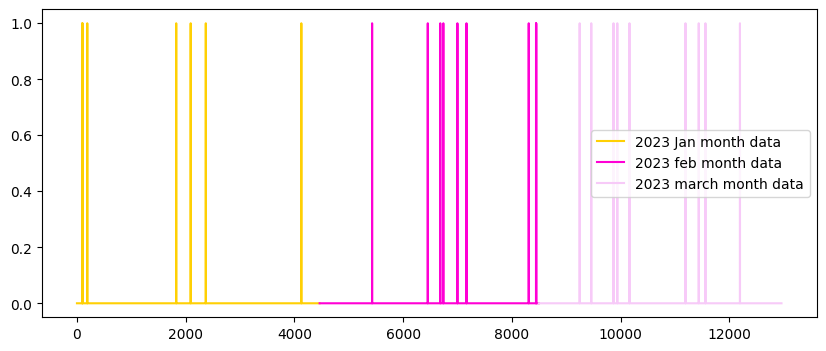

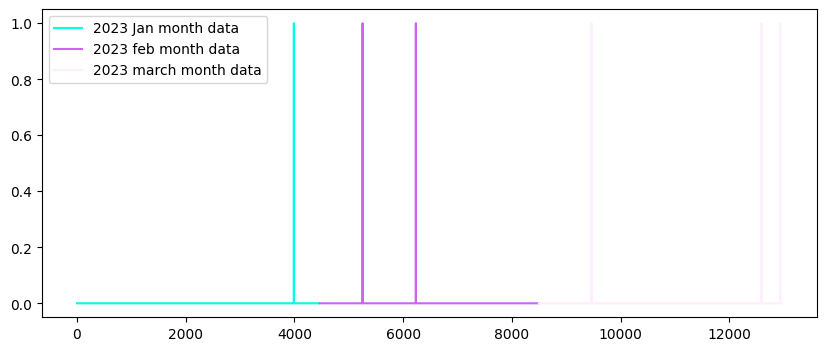

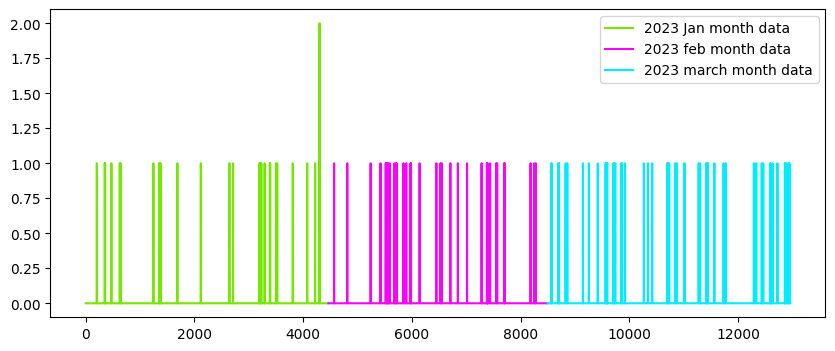

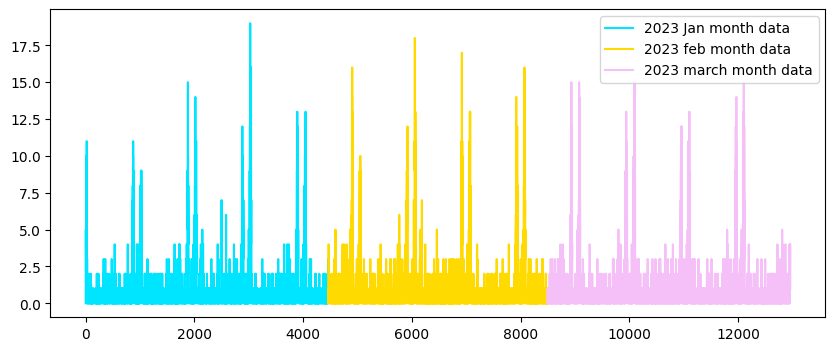

In [41]:
def uniqueish_color():
    return plt.cm.gist_ncar(np.random.random())

# Plotting the number of pickups for first 4 regions for the three months in 2023

first_x = list(range(0,4464))
second_x = list(range(4464,8496))
third_x = list(range(8496,12960))
for i in range(0,4):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_test[i][:4464], color=uniqueish_color(), label='2023 Jan month data')
    plt.plot(second_x,regions_test[i][4464:8496], color=uniqueish_color(), label='2023 feb month data')
    plt.plot(third_x,regions_test[i][8496:], color=uniqueish_color(), label='2023 march month data')
    plt.legend()
    plt.show()

## Calculating EMA (Exponential Moving Average)

In [42]:

# Testing out EMA on 2023 data

ratios_jan = pd.DataFrame()
ratios_jan['Prediction']=Jan_23_df_filled

ratios_feb = pd.DataFrame()
ratios_feb['Prediction']=Feb_23_df_filled

ratios_mar = pd.DataFrame()
ratios_mar['Prediction']=Mar_23_df_filled

In [43]:
def EA_P1_Predictions(ratios, month):
    """
    Perform EA predictions based on given ratios and month.

    Parameters:
    ratios (DataFrame): A DataFrame containing the smoothed data.
    month (str): The month for which predictions are to be made.

    Returns:
    tuple: A tuple containing the following:
        - ratios (DataFrame): The input DataFrame with additional columns for predicted values and errors.
        - mape_err (float): The mean absolute percentage error.
        - mse_err (float): The mean squared error.
    """
    predicted_value = (ratios['Prediction'].values)[0]
    alpha = 0.4
    error = []
    predicted_values = []
    bin_range = 4464
    if month == 'feb':
        bin_range = 4032
    
    for i in range(0, bin_range * 265):
        if i % bin_range == 0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value - (ratios['Prediction'].values)[i], 1))))
        predicted_value = int((alpha * predicted_value) + (1 - alpha) * ((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error) / len(error)) / (sum(ratios['Prediction'].values) / len(ratios['Prediction'].values))
    mse_err = sum([e ** 2 for e in error]) / len(error)
    return ratios, mape_err, mse_err


In [44]:
mean_err=[0]*3
median_err=[0]*3
# obtain the predictions for the three months
ratios_jan,mean_err[0],median_err[0]=EA_P1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=EA_P1_Predictions(ratios_feb,'feb')
ratios_jan,mean_err[2],median_err[2]=EA_P1_Predictions(ratios_mar,'mar')

In [45]:
print ("Exponential Moving Averages (Jan 23) -         MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Exponential Moving Averages (Feb 23) -         MAPE: ",mean_err[1],"      MSE: ",median_err[1])
print ("Exponential Moving Averages (Mar 23) -         MAPE: ",mean_err[2],"      MSE: ",median_err[2])

Exponential Moving Averages (Jan 23) -         MAPE:  0.28790833290076523       MSE:  5.427093900047339
Exponential Moving Averages (Feb 23) -         MAPE:  0.31922058935462233       MSE:  8.706781596286314
Exponential Moving Averages (Mar 23) -         MAPE:  0.3428988634271942       MSE:  12.390581253804017


In [46]:
# Adding region ID to the dataframe
ratios_jan['region ID'] = (ratios_jan.index // 4464).astype(int)
display(ratios_jan)


,Prediction,EA_P1_Predicted,EA_P1_Error,region ID
0,0,0,0.0,0
1,0,0,0.0,0
2,0,0,0.0,0
3,0,0,0.0,0
4,0,0,0.0,0
...,...,...,...,...
1182955,0,0,0.0,264
1182956,0,0,0.0,264
1182957,0,0,0.0,264
1182958,0,0,0.0,264


In [47]:
# Plotting Actual vs Predicted values for a subset of the data

temp_ratio_jan = ratios_jan[ratios_jan['region ID'] == 165]
temp_ratio_jan2 = temp_ratio_jan.reset_index()
display(temp_ratio_jan2)
temp_ratio_jan3 = temp_ratio_jan2[(temp_ratio_jan2['index'] > 737000) & (temp_ratio_jan2['index'] < 737100)]

,index,Prediction,EA_P1_Predicted,EA_P1_Error,region ID
0,736560,0,0,0.0,165
1,736561,1,0,1.0,165
2,736562,1,0,1.0,165
3,736563,0,0,0.0,165
4,736564,0,0,0.0,165
...,...,...,...,...,...
4459,741019,11,3,8.0,165
4460,741020,0,7,7.0,165
4461,741021,2,2,0.0,165
4462,741022,5,2,3.0,165


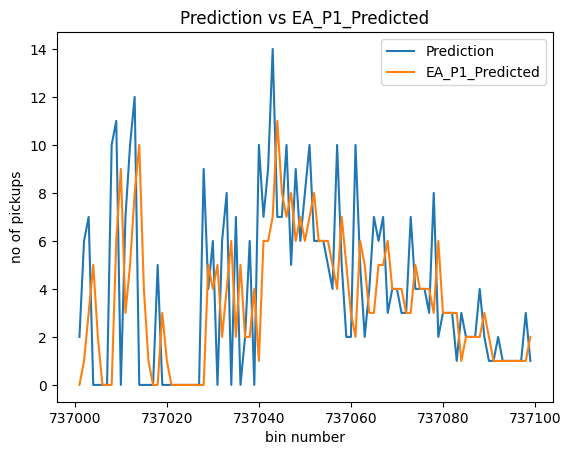

In [48]:
# Plotting the data
plt.plot(temp_ratio_jan3['index'],temp_ratio_jan3['Prediction'], label='Prediction')
plt.plot(temp_ratio_jan3['index'],temp_ratio_jan3['EA_P1_Predicted'], label='EA_P1_Predicted')
plt.xlabel('bin number')
plt.ylabel('no of pickups')
plt.title('Actual Values vs EA_P1_Predicted Values')
plt.legend()  # Add legend
plt.show()

## Preparing test and train datasets

In [49]:
number_of_time_stamps = 5 # Deciding no of bins/intervals to consider

## Creating weekday and bins features

In [52]:
# Here we will be creating a feature matrix consisting of past 5 bins/intervals data for each region

output_test = []
tsne_feature_test = []
tsne_weekday_test = []
tsne_region_test = []
tsne_feature_test = [0]*number_of_time_stamps
for i in range(0,265):
    tsne_region_test.append([i]*12955)
    # jan 1st 2023 is sunday, so we can start our day from : "(int(k/144))%7"
    tsne_weekday_test.append([int(((int(k/144))%7)%7) for k in range(5,4464+4032+4464)])
    # Stacking the past 5 bins/intervals data for each region
    tsne_feature_test = np.vstack((tsne_feature_test, [regions_test[i][r:r+number_of_time_stamps] for r in range(0,len(regions_test[i])-number_of_time_stamps)]))
    output_test.append(regions_test[i][5:])
tsne_feature_test = tsne_feature_test[1:]

In [53]:
output_train = []
tsne_feature_train = []
tsne_region_train = []
tsne_weekday_train = []
tsne_feature_train = [0]*number_of_time_stamps
for i in range(0,265):
    tsne_region_train.append([i]*12955)
    # jan 1st 2022 is saturday, so we start our day from 6: "(int(k/144))%7+6"
    
    tsne_weekday_train.append([int(((int(k/144))%7+6)%7) for k in range(5,4464+4032+4464)])
    # Stacking the past 5 bins/intervals data for each region
    tsne_feature_train = np.vstack((tsne_feature_train, [regions_train[i][r:r+number_of_time_stamps] for r in range(0,len(regions_test[i])-number_of_time_stamps)]))
    output_train.append(regions_train[i][5:])
tsne_feature_train = tsne_feature_train[1:]

In [54]:
print(tsne_feature_train)
print(len(tsne_feature_train))

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 ...
 [0 0 4 0 2]
 [0 4 0 2 0]
 [4 0 2 0 0]]
3433075


## Calculating EMA to add as a feature to regression model

In [55]:
alpha=0.4

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 12960 values
predicted_values=[]
# predict_list is a list of lists [[x5,x6,x7..x12960], [x5,x6,x7..x12960], [x5,x6,x7..x12960], [x5,x6,x7..x12960], [x5,x6,x7..x12960], .. 265 lists]
predict_list_test = []
tsne_flat_exp_avg = []
for r in range(0,265):
    for i in range(0,12960):
        if i==0:
            predicted_value= regions_test[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_test[r][i]))
    predict_list_test.append(predicted_values[5:])
    predicted_values=[]

In [56]:
# Performing the same for the training data
alpha=0.4
predicted_values=[]
predict_list_train = []
tsne_flat_exp_avg = []
for r in range(0,265):
    for i in range(0,12960):
        if i==0:
            predicted_value= regions_train[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_train[r][i]))
    predict_list_train.append(predicted_values[5:])
    predicted_values=[]

## Applying FFT to get Amplitudes and Frequencies as features

In [ ]:
"""
Using Fast Fourier Transform to extract the top 5 amplitudes and frequencies for each region in the training data
These are then repeated for all the 12955 bins/intervals for each respective region  

Amplitude helps us to understand the strength of the signal or feature in our data 
whereas Frequency helps us to understand the peroiodicity of the signal or feature in our data

"""

amplitudes_train = []
frequencies_train = []
size = 12960 
for i in range(265):
    amp  = np.abs((np.fft.fft(regions_train[i][0:size]))[:int(size/2)])
    freq = np.abs((np.fft.fftfreq(size, 1))[:int(size/2)]) 
    amp_ind = np.argsort(-amp)[1:]    
    amp_top = []
    freq_top = []
    for j in range(0,5):   
        amp_top.append(amp[amp_ind[j]])
        freq_top.append(freq[amp_ind[j]])
    amplitudes_train.extend([amp_top]*12955)
    frequencies_train.extend([freq_top]*12955)

In [58]:
"""
Using Fast Fourier Transform to extract the top 5 amplitudes and frequencies for each region in the testing data
These are then repeated for all the 12955 bins/intervals for each respective region  

Amplitude helps us to understand the strength of the signal or feature in our data 
whereas Frequency helps us to understand the peroiodicity of the signal or feature in our data

"""

amplitudes_test = []
frequencies_test = []
size = 12960 
for i in range(265):
    amp  = np.abs((np.fft.fft(regions_train[i][0:size]))[:int(size/2)])
    freq = np.abs((np.fft.fftfreq(size, 1))[:int(size/2)]) 
    amp_ind = np.argsort(-amp)[1:]    
    amp_top = []
    freq_top = []
    for j in range(0,5):   
        amp_top.append(amp[amp_ind[j]])
        freq_top.append(freq[amp_ind[j]])
    amplitudes_test.extend([amp_top]*12955)
    frequencies_test.extend([freq_top]*12955)

In [59]:
# Flattening list of lists to a single list

tsne_train_region = sum(tsne_region_train, [])
tsne_train_weekday = sum(tsne_weekday_train, [])
tsne_train_output = sum(output_train, [])
tsne_train_exp_avg = sum(predict_list_train,[])

tsne_test_region = sum(tsne_region_test, [])
tsne_test_weekday = sum(tsne_weekday_test, [])
tsne_test_output = sum(output_test, [])
tsne_test_exp_avg = sum(predict_list_test,[])

In [60]:
# Collating all features for each region into single lists
train_features =  [tsne_feature_train[i*12955:(12955*i)+12955] for i in range(0,265)]
test_features =  [tsne_feature_test[i*12955:(12955*i)+12955] for i in range(0,265)]

amplitudes_train =  [amplitudes_train[i*12955:(12955*i)+12955] for i in range(0,265)]
amplitudes_test =  [amplitudes_test[i*12955:(12955*i)+12955] for i in range(0,265)]

frequencies_train =  [frequencies_train[i*12955:(12955*i)+12955] for i in range(0,265)]
frequencies_test =  [frequencies_test[i*12955:(12955*i)+12955] for i in range(0,265)]

In [61]:
print(len(train_features))

265


In [62]:
# preview of no of pickups in past 5 intervals for each bin for the last(264) region
train_features[264]

array([[11,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       ...,
       [ 0,  0,  4,  0,  2],
       [ 0,  4,  0,  2,  0],
       [ 4,  0,  2,  0,  0]], dtype=int64)

In [63]:
# preview of top 5 frequencies for each bin for the last(264) region
frequencies_train[264]

[[0.16666666666666666,
  0.3333333333333333,
  0.0010030864197530865,
  0.006944444444444444,
  0.4989969135802469],
 [0.16666666666666666,
  0.3333333333333333,
  0.0010030864197530865,
  0.006944444444444444,
  0.4989969135802469],
 [0.16666666666666666,
  0.3333333333333333,
  0.0010030864197530865,
  0.006944444444444444,
  0.4989969135802469],
 [0.16666666666666666,
  0.3333333333333333,
  0.0010030864197530865,
  0.006944444444444444,
  0.4989969135802469],
 [0.16666666666666666,
  0.3333333333333333,
  0.0010030864197530865,
  0.006944444444444444,
  0.4989969135802469],
 [0.16666666666666666,
  0.3333333333333333,
  0.0010030864197530865,
  0.006944444444444444,
  0.4989969135802469],
 [0.16666666666666666,
  0.3333333333333333,
  0.0010030864197530865,
  0.006944444444444444,
  0.4989969135802469],
 [0.16666666666666666,
  0.3333333333333333,
  0.0010030864197530865,
  0.006944444444444444,
  0.4989969135802469],
 [0.16666666666666666,
  0.3333333333333333,
  0.001003086419753

In [64]:
"""  
Horizontally stacking the features for each region to create a single feature matrix for training and testing data
"""


train_new_features = []
test_new_features = []
train_frequency =[]
test_frequency = []
train_amplitude = []
test_amplitude = []

for i in range(0,265):
    train_new_features.extend(train_features[i])
    # print(len(train_new_features))
    test_new_features.extend(test_features[i])
    train_frequency.extend(frequencies_train[i])
    # print(len(train_frequency))
    test_frequency.extend(frequencies_test[i])
    train_amplitude.extend(amplitudes_train[i])
    test_amplitude.extend(amplitudes_test[i])

train_new_features_amp_freq=np.hstack((train_new_features,train_frequency,train_amplitude))
test_new_features_amp_freq=np.hstack((test_new_features,test_frequency,test_amplitude))

### Finalizing Model Input Frame

In [65]:
"""  
Finalizing the feature matrix for training and testing data.
features are as follows:
1. ft_1 : no of pickups in the T-1 th interval
2. ft_2 : no of pickups in the T-2 th interval
3. ft_3 : no of pickups in the T-3 th interval
4. ft_4 : no of pickups in the T-4 th interval
5. ft_5 : no of pickups in the T-5 th interval
6. f_1 : top 1 frequency value for the bin and region
7. f_2 : top 2 frequency value for the bin and region
8. f_3 : top 3 frequency value for the bin and region
9. f_4 : top 4 frequency value for the bin and region
10. f_5 : top 5 frequency value for the bin and region
11. a_1 : top 1 amplitude value for the bin and region
12. a_2 : top 2 amplitude value for the bin and region
13. a_3 : top 3 amplitude value for the bin and region
14. a_4 : top 4 amplitude value for the bin and region
15. a_5 : top 5 amplitude value for the bin and region
16. region : PULocationID
17. weekday : day of the week 0 being sunday and 6 being saturday
18. exp_avg : exponential weighted moving average for the bin and region
"""
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1','f_1','f_2','f_3','f_4','f_5','a_1','a_2','a_3','a_4','a_5']
# columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features_amp_freq, columns=columns) 
df_train['region'] = tsne_train_region
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)
df_train.head()

(3433075, 18)


In [66]:
# similarly for testing data

columns = ['ft_5','ft_4','ft_3','ft_2','ft_1','f_1','f_2','f_3','f_4','f_5','a_1','a_2','a_3','a_4','a_5']
df_test = pd.DataFrame(data=test_new_features_amp_freq, columns=columns) 
df_test['region'] = tsne_test_region
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg

print(df_test.shape)

(3433075, 18)


In [143]:
# saving df_test as past_data.pkl

pickle_file = open('past_data.pkl', 'wb') 
pickle.dump(df_test, pickle_file)
pickle_file.close()

## Using XGB Regressor

In [122]:
"""  
Training the XGBoost model using GridSearchCV to find the best hyperparameters for the model
"""

from xgboost import XGBRegressor
model = XGBRegressor()
params = {'n_jobs':[-1],
          'subsample':[0.8],
          'min_child_weight':[3],
          'learning_rate':[0.1],
          'n_estimators':[1000] ,
          'reg_lambda':[200],
          'max_depth': [3],
          'tree_method': ['gpu_hist']}

xgb_model = GridSearchCV(model, params, scoring = 'neg_mean_absolute_error', cv = None)
xgb_model.fit(df_train, tsne_train_output)



GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [3],
                         'min_child_weight': [3], 'n_estimators': [1000],
                         'n_jobs': [-1], 'reg_lambda': [200],
                         'subsample': [0.8], 'tree_method': ['gpu_hist']},
             scoring='neg_mean_absolute_error')

In [128]:
# saving the model as xgb_model_final.pkl
with open('xgb_model_final.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

In [68]:
#Reading the model from the disk
with open('xgb_model_final.pkl', 'rb') as f:
    xgb_model = pickle.load(f)   

In [123]:
# Predicting the values for the training and testing data
y_pred = xgb_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = xgb_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

In [124]:
# Calculating the mean absolute percentage error for the training and testing data
train_mape=[]
test_mape=[]
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [125]:
print ("|XgBoost Regression -                         Train: ",train_mape,"      Test:",test_mape,"|")

|XgBoost Regression -                         Train:  [0.3007110089902275]       Test: [0.31194276272206295] |


In [127]:
print(df_test.columns)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'f_1', 'f_2', 'f_3', 'f_4',
       'f_5', 'a_1', 'a_2', 'a_3', 'a_4', 'a_5', 'region', 'weekday',
       'exp_avg'],
      dtype='object')


In [126]:
# Feature importances for the model
xgb_model.best_estimator_.feature_importances_

array([2.8691664e-02, 3.8872510e-02, 6.0667280e-02, 1.8604377e-02,
       1.5185020e-03, 6.3300499e-04, 8.3293527e-04, 8.0760597e-04,
       7.4801181e-04, 7.7734963e-04, 8.4888674e-03, 3.5632823e-03,
       1.8426666e-02, 9.1602514e-03, 3.6701716e-03, 1.2266199e-03,
       7.3625706e-04, 8.0257469e-01], dtype=float32)